# Multi-agent Collaboration


## Overview

A single agent can usually perform well using a small set of tools to solve a specific task. However, even powerful models like GPT-4 may struggle when given many different tools to solve a complex task.

One way to approach complicated tasks is through a _"divide-and-conquer"_ approach. Create a specialized agent for each task and route tasks to the correct _"expert"_.

The code from this notebook is adapted from the [LangGraph tutorial](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/multi-agent-collaboration). The ideas in this notebook is inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.

The graph that we'll build will look something like the following diagram:

![multi_agent diagram](img/simple_multi_agent_diagram.png)

**Figure 1**: Image from [LangGraph](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/multi-agent-collaboration)

## Setup

Before we begin, please make sure you have setup the `.env` file in the project 
directory as described in [`README.md`](README.md).

Next, we will load in the necessary environment variables (e.g., API keys) for this notebook:

In [1]:
import os
from dotenv import load_dotenv

_ = load_dotenv()

assert os.environ.get("GOOGLE_API_KEY")

## Create Agents

The following helper function will help create agents. These agents will then be nodes in the graph.

In [2]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import (
    ChatPromptTemplate, 
    MessagesPlaceholder,
)
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.tools import BaseTool
from langchain_core.runnables import RunnableSequence


def create_agent(
    model: BaseChatModel, 
    tools: list[BaseTool], 
    system_message: str
) -> RunnableSequence:
    """
    Create an agent that will be a node in the graph.

    Args:
        model: The LLM that powers this agent.
        tools: List of tools to be called by the LLM.
        system_message: The system message passed to the LLM 
            to configure its behaviour.

    Returns:
        A chain that can be invoked.
    """
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, "
                "collaborating with other assistants. "
                "Use the provided tools to progress "
                "towards answering the question. "
                "If you are unable to fully answer, "
                "that's OK, another assistant with "
                "different tools will help where "
                "you left off. Execute what you can "
                "to make progress. If you or any of "
                "the other assistants have the "
                "final answer or deliverable, "
                "prefix your response with FINAL ANSWER "
                "so the team knows to stop. "
                "You have access to the following tools: {tool_names}."
                "\n\n"
                "{system_message}",
            ),
            MessagesPlaceholder(
                variable_name="messages"
            ),
        ]
    )
    prompt = prompt.partial(
        system_message=system_message
    )
    prompt = prompt.partial(
        tool_names=", ".join(
            tool.name for tool in tools
        )
    )
    return (
        prompt 
        | model.bind_tools(tools)
    )

## Define Tools

We will also define some tools that our agents will use.

### Fetch historical stock data tool

This tool is used by the `stock_researcher` agent to fetch historical data for a given stock's ticker symbol. This tool uses the [`yfinance`](https://github.com/ranaroussi/yfinance) library to download market data from [Yahoo! finance](https://finance.yahoo.com/).

In [3]:
from typing import Annotated

from langchain_core.tools import tool

import pandas as pd
import yfinance as yf


@tool(
    response_format="content_and_artifact"
)
def get_historical_stock_data(
    ticker_symbol: Annotated[
        str, 
        "A ticker symbol is a stock symbol; "
        "an abbreviation of a company's name that "
        "uniquely identifies its publicly traded "
        "shares on stock exchanges. Examples of "
        "ticker symbols are GOOGL for Google, "
        "AMZN for Amazon, MSFT for Microsoft, "
        "AAPL for Apple."
    ],
) -> tuple[str, pd.DataFrame]:
    """
    Fetch the historical stock data for a given 
    stock ticker symbol.

    Example:
        .. code-block:: python

            # fetch historical stock data for Apple Inc
            get_historical_stock_data('AAPL')

    Returns: 
        A pandas `DataFrame` with columns: 
        `Date`, `Open`, `High`, `Low`, `Close`, `Volume`.
        The `Date` column will be used as the `DatetimeIndex`.
    """
    stock = yf.Ticker(ticker_symbol)    

    # artifact is a pandas DataFrame used by 
    # the plot_chart tool
    hist_data = stock.history(
        # 1 day interval
        interval='1d', 
        # 3 months history
        period='3mo',
        # do NOT Include Dividends and 
        # Stock Splits in results
        actions=False,
    )

    # content is for the LLM
    content = (
        "Successfully fetched historical stock "
        f"data for `{ticker_symbol}`."
    )

    # returns a (content, artifact) tuple
    return (content, hist_data)

Let's try invoking the tool to see what we get back:

In [4]:
from langchain_core.messages import ToolCall

# normally, this would be generated by the LLM
tool_call = ToolCall(
    name="get_historical_stock_data",
    args={
        "ticker_symbol": "SPY"
    },
    id=123,          # required
    type="tool_call" # required
)

tool_result = get_historical_stock_data.invoke(
    input=tool_call
)

In [5]:
tool_result.content

'Successfully fetched historical stock data for `SPY`.'

Below we can see that the tool also returned an artifact, which is a pandas `DataFrame` that will be used by the `plot_chart` tool:

In [6]:
type(tool_result.artifact)

pandas.core.frame.DataFrame

Take a look at the last 5 rows of the stock's historical data:

In [7]:
stock_hist_data = tool_result.artifact
stock_hist_data.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2024-08-21 00:00:00-04:00,559.770020,562.109985,554.729980,560.619995,41514600
2024-08-22 00:00:00-04:00,562.559998,563.179993,554.979980,556.219971,56121500
2024-08-23 00:00:00-04:00,559.530029,563.090027,557.289978,562.130005,50639400
2024-08-26 00:00:00-04:00,563.179993,563.909973,559.049988,560.789978,35788600
2024-08-27 00:00:00-04:00,559.489990,562.059998,558.320007,561.559998,32627800


### Plot Chart Tool

This tool is used by the `chart_generator` agent to plot a chart of a stock's historical data (`Date`, `Open`, `High`, `Low`, `Close`, `Volume`). This tool uses the [`mplfinance`](https://github.com/matplotlib/mplfinance) library which is an extension of [matplotlib](https://matplotlib.org/) for the visualization, and visual analysis of financial data.

In [8]:
from langgraph.prebuilt import InjectedState

import mplfinance as mpf


@tool(
    parse_docstring=True
)
def plot_chart(    
    state: Annotated[
        dict, 
        InjectedState
    ],
) -> str:
    """
    Plot a chart of a stock's historical data. 

    Args:
        state: The current state of the graph 
            containing the historical stock 
            data as a pandas DataFrame.
    """
    mpf.plot(
        data=state['stock_data'],
        type='candle',
        mav=2,
        mavcolors=['magenta'],
        volume=True,
    )

    # content string for the LLM
    return (
        "Finished plotting chart."
    )

We need to pass a pandas `DataFrame` as an argument to the `plot_chart` tool, but we don't want the model to try to generate this input when calling the tool. Instead, we use the `InjectedState` annotation to mark arguments as required graph state. These arguments will not be generated by the model. When using `ToolNode`, the graph state will automatically be passed in to the relevant tools.

> See also: [LangGraph docs: How to pass graph state to tools](https://langchain-ai.github.io/langgraph/how-tos/pass-run-time-values-to-tools/)

If we look at the input schema for the tool, we'll see that `state` is still listed:

In [9]:
plot_chart.input_schema.schema()

{'title': 'plot_chartSchema',
 'description': "Plot a chart of a stock's historical data. ",
 'type': 'object',
 'properties': {'state': {'title': 'State',
   'description': 'The current state of the graph containing the historical stock data as a pandas DataFrame.',
   'type': 'object'}},
 'required': ['state']}

But if we look at the tool call schema, which is what is passed to the model for tool-calling, `state` has been removed:

In [10]:
plot_chart.tool_call_schema.schema()

{'title': 'plot_chart',
 'description': "Plot a chart of a stock's historical data.",
 'type': 'object',
 'properties': {}}

Let's try invoking the tool to see what we get back:

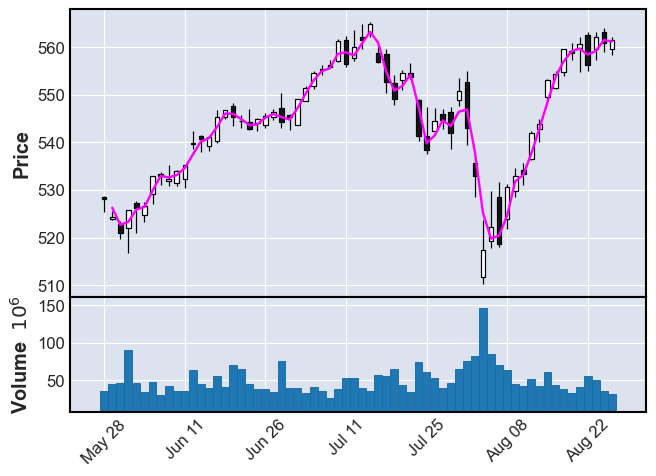

In [11]:
# mock graph state just for testing purposes
fake_state = {
    "stock_data": stock_hist_data,
}

# normally, this would be generated by the LLM
tool_call = ToolCall(
    name="plot_chart",
    args={
        # this arg will be automatically 
        # injected in by the ToolNode
        "state": fake_state,
    },
    id=123,          # required
    type="tool_call" # required
)

tool_result = plot_chart.invoke(
    input=tool_call
)

In [12]:
tool_result.content

'Finished plotting chart.'

## Create graph

After we've defined the tools for the agents, we'll create the agents and tell them how to talk to each other using LangGraph.

### Define State

First define the state of the graph. This will be a list of messages, a key to track the most recent sender, and a pandas `DataFrame` containing a stock's historical data.

> See also: [LangGraph Concepts > State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)

In [13]:
import operator
from typing import (
    Annotated, 
    Sequence, 
    TypedDict
)


class AgentState(TypedDict):
    """
    Schema of the graph representing the graph's state.
    """
    messages: Annotated[
        Sequence[BaseMessage], 
        operator.add
    ]
    """List of messages that will be accumulated."""
    
    sender: str
    """The most recent node that sent this state."""
    
    stock_data: pd.DataFrame
    """Pandas DataFrame containing historical data of a stock."""

### Define Agent Nodes

Create the chat model (LLM) that will power the agents:

In [17]:
from langchain_google_genai import ChatGoogleGenerativeAI

chat_model = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0,
)

Next, let's define the nodes for the agents. To make things easier, we'll create a helper function to create a node for a given agent.

In [16]:
from langchain_core.messages import AIMessage
from langchain_core.runnables import Runnable


def agent_node(
    input_state: AgentState, 
    agent: Runnable, 
    name: str
) -> AgentState:
    """
    Create a node on the graph for a given agent.

    Args:
        input_state: Current state of the graph.
        agent: The agent is just a chat model that 
            can call tools.
        name: The name of the node in the graph.
        
    Returns:
        New state of the graph.
    """
    result: BaseMessage = agent.invoke(input_state)
    
    if isinstance(result, ToolMessage):
        pass
    else:
        # ignore message `type`, fix it as `AIMessage`
        # `name` attribute set to agent's name
        result_dict = result.dict(
            exclude={"type", "name"}
        )
        result = AIMessage(
            **result_dict, 
            name=name
        )

    # Output state
    return AgentState(
        messages=[result],
        
        # Keep track of the agent that sent 
        # the most recent message, so that we 
        # know who to route to next.
        sender=name,
    )

#### Stock Researcher Agent

Create the stock researcher agent and its node in the graph. This agent is responsible for fetching historical data of a stock given a stock's ticker symbol. 

In [21]:
from functools import partial


stock_researcher_agent = create_agent(
    model=chat_model,
    tools=[
        get_historical_stock_data
    ],
    system_message=(
        "Given a stock's ticker symbol "
        "(e.g., AAPL for Apple Inc, MSFT for Microsoft Corp, etc.), "
        "your only task is to fetch that stock's historical data."
    ),
)

# stock_researcher_node(input_state: AgentState) -> AgentState
stock_researcher_node = partial(
    agent_node, 
    agent=stock_researcher_agent, 
    name="stock_researcher"
)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


#### Chart Generator Agent

Create the agent that will plot a chart of the stock data. Also, create a node in the graph for this agent.

In [22]:
chart_agent = create_agent(
    model=chat_model,
    tools=[
        plot_chart
    ],
    system_message=(
        "You will be provided with the historical "
        "data of a stock. Your only task is to "
        "plot a chart of this data."
    ),
)

chart_generator_node = partial(
    agent_node, 
    agent=chart_agent, 
    name="chart_generator"
)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


### Define Tool Node

Define a node to run the tools used by the agents.

In [76]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(
    tools=[
        web_search_tool, 
        plot_time_series
    ]
)

### Define Router

Define some of the edge logic that is needed to decide what to do based on results generated by the agents.

In [77]:
from typing import Literal

from langgraph.graph import END


def router(
    state: AgentState
) -> Literal["call_tool", END, "continue"]:
    """
    Routes to different nodes based on the 
    agent's output.

    Args:
        state: Current state of the graph that includes 
            the previous agent's output.

    Returns:
        One of the following strings:
        - `call_tool`: If an agent is invoking a tool.
        - `__end__`: If an agent decides that the work is finished.
        - `continue`: Hand control over to the other agent.
    """
    messages = state["messages"]
    last_message: AIMessage = messages[-1]    

    if last_message.tool_calls:
        # Previous agent is invoking a tool
        return "call_tool"
    
    if "FINAL ANSWER" in last_message.content:
        # One of the agent has decided that 
        # the work is finished
        return END

    # Hand control over to the other agent
    return "continue"

### Build the Graph

We can now put it all together and build the graph.

In [78]:
from langgraph.graph import (
    START, 
    StateGraph
)


workflow = StateGraph(
    state_schema=AgentState
)

workflow.add_node("researcher", research_agent_node)
workflow.add_node("chart_generator", chart_agent_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    source="researcher",
    path=router,
    path_map={
        "continue": "chart_generator", 
        "call_tool": "call_tool", 
        "__end__": END
    },
)

workflow.add_conditional_edges(
    source="chart_generator",
    path=router,
    path_map={
        "continue": "researcher", 
        "call_tool": "call_tool", 
        "__end__": END
    },
)

# Each agent node updates the 'sender' field
# the tool calling node does not, meaning
# this edge will route back to the original agent
# who invoked the tool
workflow.add_conditional_edges(
    source="call_tool",
    path=lambda state: state["sender"],
    path_map={
        "researcher": "researcher",
        "chart_generator": "chart_generator",
    }
)

workflow.add_edge(
    start_key=START, 
    end_key="researcher"
)

graph = workflow.compile()

Let's visualize the graph that we've built:

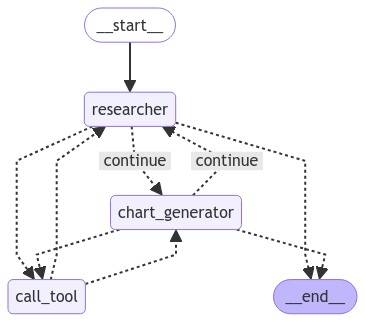

In [79]:
from IPython.display import Image, display

display(
    Image(
        graph.get_graph(xray=True).draw_mermaid_png()
    )
)

## Invoke

After we have built the graph, we can now invoke it. Let's have it plot a chart for us:

In [ ]:
events = graph.stream(
    input={
        "messages": [
            HumanMessage(
                content=(
                    "1. Fetch the average temperature (in Celsius) in "
                    "Kuala Lumpur for the past 7 days.\n"
                    "2. Plot a chart of the temperature (y-axis) "
                    "vs date (x-axis).\n"
                )
            )
        ],
    },
    config={
        # Maximum number of steps to
        # take in the graph
        "recursion_limit": 150
    },
)

for s in events:
    print(s)
    print("----")